# Imports

In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, root_mean_squared_error
import seaborn as sns
import kagglehub
from datetime import datetime


# Regression with Tensorflow Decision Forests

## Download and store data into a dataframe 

In [2]:
# Download latest version
path = kagglehub.dataset_download("mssmartypants/paris-housing-price-prediction")

print("Path to dataset files:", path)

100%|██████████| 269k/269k [00:00<00:00, 2.66MB/s]

Extracting files...
Path to dataset files: /home/flopez0294/.cache/kagglehub/datasets/mssmartypants/paris-housing-price-prediction/versions/2


In [3]:
dfHousing = pd.read_csv(os.path.join(path, "ParisHousing.csv"))
dfHousing.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [4]:
dfSize = np.shape(dfHousing)
print(dfSize)
n = dfSize[0]
col = dfSize[1]

(10000, 17)


## Preprocessing

In [5]:
# check for NA values
print(dfHousing.isna().sum())

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64


No NA values so continue

In [6]:
# add current age of house instead of the year the house was built in regression it can be seen as increase in age leads to decrease in price
currYear = int(datetime.now().year)
print(currYear)
dfHousing['age'] = currYear - dfHousing['made']
print(dfHousing['age'])
dfHousing = dfHousing.drop(columns='made')
dfHousing.head()

2025
0       20
1       10
2        4
3       13
4       35
        ..
9995    16
9996    35
9997    20
9998    15
9999    31
Name: age, Length: 10000, dtype: int64


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,age
0,75523,3,0,1,63,9373,3,8,0,1,4313,9005,956,0,7,7559081.5,20
1,80771,39,1,1,98,39381,8,6,1,0,3653,2436,128,1,2,8085989.5,10
2,55712,58,0,1,19,34457,6,8,0,0,2937,8852,135,1,9,5574642.1,4
3,32316,47,0,0,6,27939,10,4,0,1,659,7141,359,0,3,3232561.2,13
4,70429,19,1,1,90,38045,3,7,1,0,8435,2429,292,1,4,7055052.0,35


Look at correlation of the data

                   squareMeters  numberOfRooms   hasYard   hasPool    floors  \
squareMeters           1.000000       0.009573 -0.006650 -0.005594  0.001109   
numberOfRooms          0.009573       1.000000 -0.011240  0.017015  0.022244   
hasYard               -0.006650      -0.011240  1.000000  0.015514 -0.000883   
hasPool               -0.005594       0.017015  0.015514  1.000000 -0.004006   
floors                 0.001109       0.022244 -0.000883 -0.004006  1.000000   
cityCode              -0.001541       0.009040  0.006760  0.008072  0.002207   
cityPartRange          0.008758       0.008340  0.005023  0.014613 -0.004921   
numPrevOwners          0.016619       0.016766  0.004279 -0.006848  0.002463   
isNewBuilt            -0.010667      -0.002865 -0.008370  0.000188  0.002458   
hasStormProtector      0.007480      -0.001656 -0.007598 -0.001001 -0.008566   
basement              -0.003960      -0.013990 -0.008558 -0.007268  0.006228   
attic                 -0.000588       0.

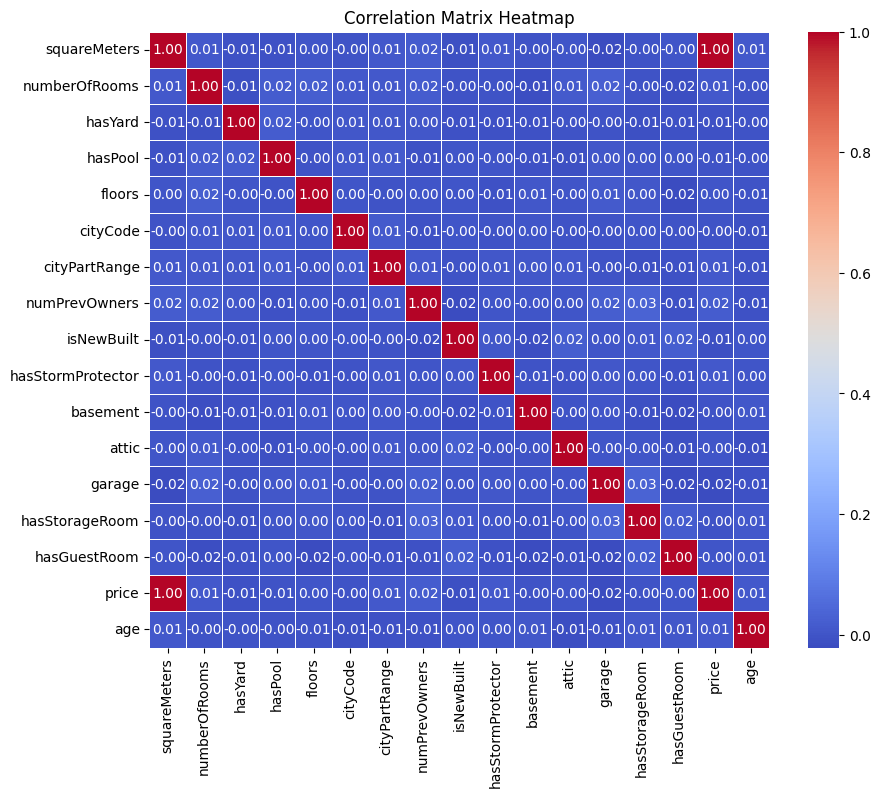

In [7]:
correlation_matrix = dfHousing.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Notice price and squareMeters are highly correlated.

# Train first model

In [ ]:
# split data
dfHousing.head()
x_train, x_test, y_train, y_test = train_test_split(dfHousing.drop(columns=['price']), dfHousing['price'], test_size = 0.2, random_state = 67)
print(np.shape(x_train))
print(np.shape(x_test))


# convert to tensorflow datasets
x_train['price'] = y_train
x_test['price'] = y_test


dfTrain = x_train
dfTest = x_test
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dfTrain, label="price", task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dfTest, label="price", task=tfdf.keras.Task.REGRESSION)


(7000, 16)
(3000, 16)


W0000 00:00:1764736166.123792   14231 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [37]:

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION)

# Train the model.
model_1.fit(train_ds)

Use 12 thread(s) for training
Use /tmp/tmpq_l4l5kw as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

In [38]:
model_1.summary()

Model: "random_forest_model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (16):
	age
	attic
	basement
	cityCode
	cityPartRange
	floors
	garage
	hasGuestRoom
	hasPool
	hasStorageRoom
	hasStormProtector
	hasYard
	isNewBuilt
	numPrevOwners
	numberOfRooms
	squareMeters

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.      "squareMeters"  0.427760 ################
    2.             "attic"  0.119158 #
    3.          "cityCode"  0.118703 #
    4.          "basement"  0.118590 #
    5.            "garage"  0.116441 #
    6.               "age"  0.112368 #
    7.            "floors"  0.107843 #
    8.     "numberOfRooms"  0.103290 #
    9.     "numPrevOwners"  0.

In [39]:
model_1.compile(metrics=['mse'])
evaluation = model_1.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")

inspector = model_1.make_inspector()
print(inspector.evaluation())


3/3 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - mse: 8151960576.0000

loss: 0.0000
mse: 8151960576.0000
The RMSE of this testing evaluation is: 90288.20839954684
Evaluation(num_examples=7000, accuracy=None, loss=None, rmse=92790.97099494374, ndcg=None, aucs=None, auuc=None, qini=None)


### The given RMSE is the predicted error from the true value of a house on average

In [40]:
model_1000 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=1000)

# Train the model.
model_1000.fit(train_ds)

Use 12 thread(s) for training
Use /tmp/tmp84rdx89z as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

In [44]:
model_1000.summary()

Model: "random_forest_model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (16):
	age
	attic
	basement
	cityCode
	cityPartRange
	floors
	garage
	hasGuestRoom
	hasPool
	hasStorageRoom
	hasStormProtector
	hasYard
	isNewBuilt
	numPrevOwners
	numberOfRooms
	squareMeters

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.      "squareMeters"  0.447834 ################
    2.          "cityCode"  0.118397 #
    3.          "basement"  0.116149 #
    4.             "attic"  0.115995 #
    5.            "garage"  0.115286 #
    6.               "age"  0.111236 #
    7.            "floors"  0.106670 #
    8.     "numberOfRooms"  0.104650 #
    9.     "numPrevOwners"  0.

In [45]:
model_1000.compile(metrics=['mse'])
evaluation = model_1000.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")

inspector = model_1000.make_inspector()
print(inspector.evaluation())

3/3 [==============================] - 0s 159ms/step - loss: 0.0000e+00 - mse: 7104247808.0000

loss: 0.0000
mse: 7104247808.0000
The RMSE of this testing evaluation is: 84286.70006590601
Evaluation(num_examples=7000, accuracy=None, loss=None, rmse=82903.0254421213, ndcg=None, aucs=None, auuc=None, qini=None)


In [46]:
model_2000 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2000)

# Train the model.
model_2000.fit(train_ds)
model_2000.summary()
model_2000.compile(metrics=['mse'])
evaluation = model_2000.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")

inspector = model_2000.make_inspector()
print(inspector.evaluation())

Use 12 thread(s) for training
Use /tmp/tmpb3v4pj5m as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

In [47]:
model_3000 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=3000)

# Train the model.
model_3000.fit(train_ds)
model_3000.summary()
model_3000.compile(metrics=['mse'])
evaluation = model_3000.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")

inspector = model_3000.make_inspector()
print(inspector.evaluation())

Use 12 thread(s) for training
Use /tmp/tmpxnh1hpl6 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

### Testing RMSE went up so try num_tree between 2000 3000

In [52]:
testRMSE = []
for i in range(2100, 3001, 100):
    model = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=i)
    model.fit(train_ds)
    model.compile(metrics=['mse'])
    evaluation = model.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
    testRMSE.append(np.sqrt(evaluation['mse']))
testRMSE = np.array(testRMSE)
minRMSE = np.min(testRMSE)
minIdx = np.argmin(testRMSE)
print(f"At Idx: {minIdx} the minRMSE is {minRMSE}")

Use 12 thread(s) for training
Use /tmp/tmp88ul6_s_ as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

WE notice about 2200 trees it gives us the lowest Test RMSE so we will see if we should decrease or increase it by a bit.

In [58]:
model_2250 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2250)
model_2250.fit(train_ds)
model_2250.compile(metrics=['mse'])
evaluation = model_2250.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2250 tress: {np.sqrt(evaluation['mse'])}")

Use 12 thread(s) for training
Use /tmp/tmpqjd_1mpa as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

It increase so try decreasing it.

In [ ]:
model_2150 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2150)
model_2150.fit(train_ds)
model_2150.compile(metrics=['mse'])
evaluation = model_2150.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2150 tress: {np.sqrt(evaluation['mse'])}")

Use 12 thread(s) for training
Use /tmp/tmpl0p0ke5n as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

In [ ]:
model_2190 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2190)
model_2190.fit(train_ds)
model_2190.compile(metrics=['mse'])
evaluation = model_2190.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2190 tress: {np.sqrt(evaluation['mse'])}")

Use 12 thread(s) for training
Use /tmp/tmpl5vmrnr7 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

In [ ]:
model_2210 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2210)
model_2210.fit(train_ds)
model_2210.compile(metrics=['mse'])
evaluation = model_2210.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2210 tress: {np.sqrt(evaluation['mse'])}")

Use 12 thread(s) for training
Use /tmp/tmpso_evaek as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

Seems that 2200 is the best number of trees with the default depth. Lets try to increase and decrease the max depth

In [79]:
depth = 20
model_2200 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2200, max_depth=depth)
model_2200.fit(train_ds)
model_2200.compile(metrics=['mse'])
evaluation = model_2200.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2200 tress depth {depth}: {np.sqrt(evaluation['mse'])}")

Use 12 thread(s) for training
Use /tmp/tmprdq8w2kg as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

About 20 to 21 max depth with 2200 number of trees it gives the lowest test RMSE fo 80601.62

This gives the first 1 tree of the model up to depth 4. Must be opened.

In [12]:

html_code = tfdf.model_plotter.plot_model(model_1, max_depth=4)

with open("tree.html", "w") as f:
    f.write(html_code)


### Now try seeing what is the best number of trees with default depth (10000)

In [ ]:
model_10000 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=10000)

# Train the model.
model_10000.fit(train_ds)
    

Use 12 thread(s) for training
Use /tmp/tmptyeq91r5 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'hasStorageRoom': <tf.Te

In [ ]:
model_10000.compile(metrics=['mse'])
evaluation = model_10000.evaluate(test_ds, return_dict=True, use_multiprocessing=True,)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")


3/3 [==============================] - 9s 3s/step - loss: 0.0000e+00 - mse: 7398486528.0000

loss: 0.0000
mse: 7398486528.0000
The RMSE of this testing evaluation is: 86014.45534327356


In [ ]:
inspector = model_10000.make_inspector()
print(inspector.variable_importances())

KeyError: 'NUMERICAL'

In [18]:
y_pred_test = model_10000.predict(test_ds)
testRMSE = root_mean_squared_error(y_test, y_pred_test)
print(testRMSE)

3/3 [==============================] - 9s 3s/step
86014.45454588353
